# Homework 1
CSCI 5636  
Andrew Altomare

### Differentiation with matrices
When constructing matrices $D$ and $D_2$ for computing the finite differences
$$ u'(x)\approx Du(x)\ \ \ \ \text{and}\ \ \ \ u''(x)\approx D_2u(x) $$
we are concerned about two things in particular: how to handle irregular grids and how to handle points on or near the boundary without sacrificing stability or accuracy.

### Polynomial interpolation
Polynomial interpolation addresses both of these concerns. Polynomials can be interpolated over staggered grids just as easily as uniform grids, and the analytic derivatives of the resulting interpolants are simple and straightforward for implementing with matrices. Additionally, since these polynomials are well defined outside of the grid, taking derivatives at the boundaries is also straightforward. Consider the equation  

$$ Vc = u $$  

Where $V$ is the Vandermonde matrix, $c$ is the coefficient vector associated with the polynomial bases $(1,x,x^2,x^3,\ldots)$, and $u$ is the function for which we want a polynomial approximation. Solving for $c$ affords us a polynomial approximation of $u$, whose derivatives are easy to compute analytically.  

As derived in the lecture notes in the notebook FDHighOrder.ipynb, we recover the stencil for any order derivative by isolating rows of $V^{-1}$. Let $p$ be the interpolant that approximates $u$. Then  

\begin{align*}
p(x) &= c_0 + c_1x + c_2x^2 + \cdots\\
p(0) &= c_0 \\
p'(0) &= c_1 \\
p''(0) &= 2c_2 \\
 &\ \ \vdots \\
p^{(k)}(0) &= k!c_k \\
\end{align*}  

It's clear that we can isolate $k!c_k$ since  

$$ k!c_k = k!e_k^TV^{-1}u $$  

The following function does exactly that to produce a FD stencil for the $k^{th}$ derivative 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

def vandermonde_stencil(x,idx,k):
    """
    Compute a FD stencil based on polynomial interpolation

        Args:
            x (numpy array):  some neighborhood of the point for which a derivative is needed
            idx (int):        the index of the point in x for which a derivative is needed
            k (int):          the order of the derivative required

        Returns:
            A numpy array which can be used as a stencil in a FD matrix
    """
    xn = x-x[idx]
    V = np.vander(xn, increasing=True)
    return np.linalg.inv(V)[k]*np.math.factorial(k)

x = np.linspace(0,1,3) # three points uniformly spaced
print(vandermonde_stencil(x,1,1)) # the vandermonde_stencil is exactly the centered difference stencil on uniform grids

[-1.  0.  1.]


Below is the function `diffmat`, which produces a matrix $D$ for computing  

$$ u'(x)\approx Du(x) $$  

with the desired order of accuracy. Each row of the matrix is comprised of a `vandermonde_stencil` with length proportional to the desired order of accuracy. In particular, second order accuracy is achieved with a three point stencil, fourth order accuracy is achieved with a five point stencil, etc. So for each row in the matrix $D$, we compute the $s\times s$ inverse $V^{-1}$ where $s$ is roughly equal to the desired order of accuracy.  

For an $s$ point stencil, there are $2\lfloor s/2 \rfloor$ points on/near the boundary whose derivatives cannot be computed using a symmetric neighborhood of grid points (symmetric with respect to indices of $x$). For these points, derivatives are computed with the interpolant based on the $s$ points closest to the boundary. For example, with a 3 point stencil, $u'(x_0)$ is determined by the interpolant over $x_0,x_1,x_2$.   

Plotted are examples of D's action over $u(x) = sin(x)$ for both uniform and staggered grids compared to the true $u'(x)=cos(x)$. $sin$ has rich derivatives on the interval $(-1,1)$, so it should provide a demonstrative stress test of the operator $D$.

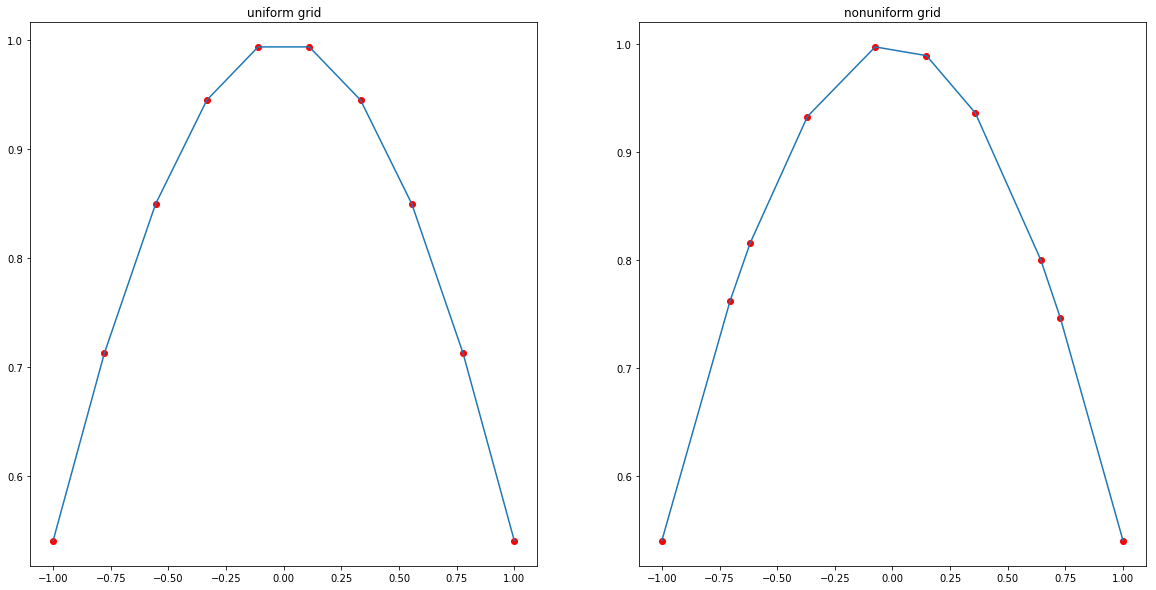

In [15]:
def diffmat(x, acc):
    """
    Produce a derivative operator D at the desired order of accuracy
    
    Args:
        x (numpy array):  grid points over some domain
        acc (int):        desired order of accuracy
        
        Returns:
            Matrix for computing derivatives over grid points
    """
    n = len(x)
    D = np.zeros((n,n))
    sz = acc+1
    ix = acc/2
    for i in range(n):
        if i <= ix:
            D[i,0:sz] = vandermonde_stencil(x[:sz], i, 1)
        elif n-i > ix:
            D[i,i-ix:i+ix+1] = vandermonde_stencil(x[i-ix:i+ix+1], ix, 1)
        else:
            D[i,n-sz:n] = vandermonde_stencil(x[-sz:], i-n, 1)
    return D

n=10
h = 2. / (n-1)
x = np.linspace(-1,1,n)
plt.subplot(121, title='uniform grid')
plt.plot(x,diffmat(x,4).dot(np.sin(x)),'ro') # 4th order accurate
plt.plot(x,np.cos(x))
offset = np.random.uniform(-h/2., h/2., n-2)
x[1:-1] += offset
plt.subplot(122, title='nonuniform grid')
plt.plot(x,diffmat(x,4).dot(np.sin(x)),'ro') # 4th order accurate
plt.plot(x,np.cos(x))

Below is the function `diff2mat`, for computing  

$$ u''(x) \approx D_2u(x) $$  

The code is nearly identical to `diffmat` except that rows of $D_2$ follow from row 2 of the inverse Vandermonde matrix. Plotted are examples of D's action over $u(x)=cos(x)$  for both uniform and staggered grids.

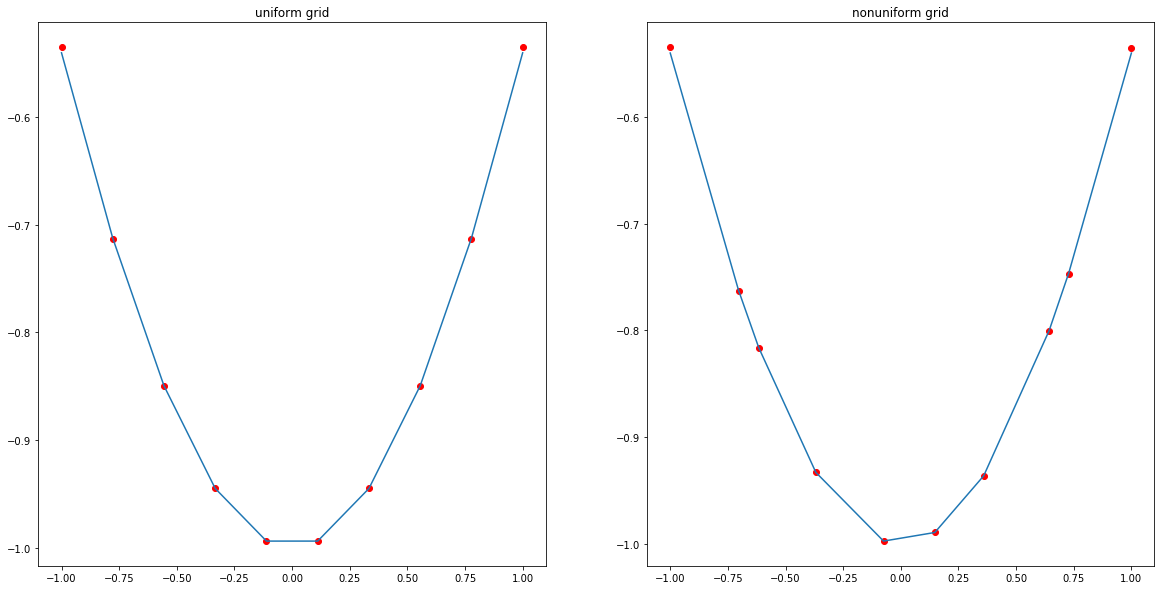

In [30]:
def diff2mat(x, acc):
    """
    Produce a second derivative operator D2 at the desired order of accuracy
    
    Args:
        x (numpy array):  grid points over some domain
        acc (int):        desired order of accuracy
    
    Returns:
        Matrix for computing second derivatives over grid points
    """
    acc += 1
    n = len(x)
    D2 = np.zeros((n,n))
    sz = acc+1
    ix = acc/2
    for i in range(n):
        if i <= ix:
            D2[i,0:sz] = vandermonde_stencil(x[:sz], i, 2)
        elif n-i > ix:
            D2[i,i-ix:i+ix+1] = vandermonde_stencil(x[i-ix:i+ix+1], ix, 2)
        else:
            D2[i,n-sz:n] = vandermonde_stencil(x[-sz:], i-n, 2)
    return D2

x = np.linspace(-1,1,n)
plt.subplot(121, title='uniform grid')
plt.plot(x,diff2mat(x,3).dot(np.cos(x)),'ro')
plt.plot(x,-np.cos(x))
x[1:-1] += offset
plt.subplot(122, title='nonuniform grid')
plt.plot(x,diff2mat(x,3).dot(np.cos(x)),'ro')
plt.plot(x,-np.cos(x))

Below is a convergence study, deomonstrating the behavior of `diffmat` and `diff2mat` under grid refinement with three different accuracy settings. Here we define the error  

$$ err = || Du - u' ||_{\infty} $$  

The infinite norm is appropriate here because we know there are a small number of points on the boundary that will lend themselves to less accurate differentiation than will points on the interior. The infinite norm exposes this much better than the Euclidean and taxicab norms by isolating the largerst term in the vector $Du - u'$.

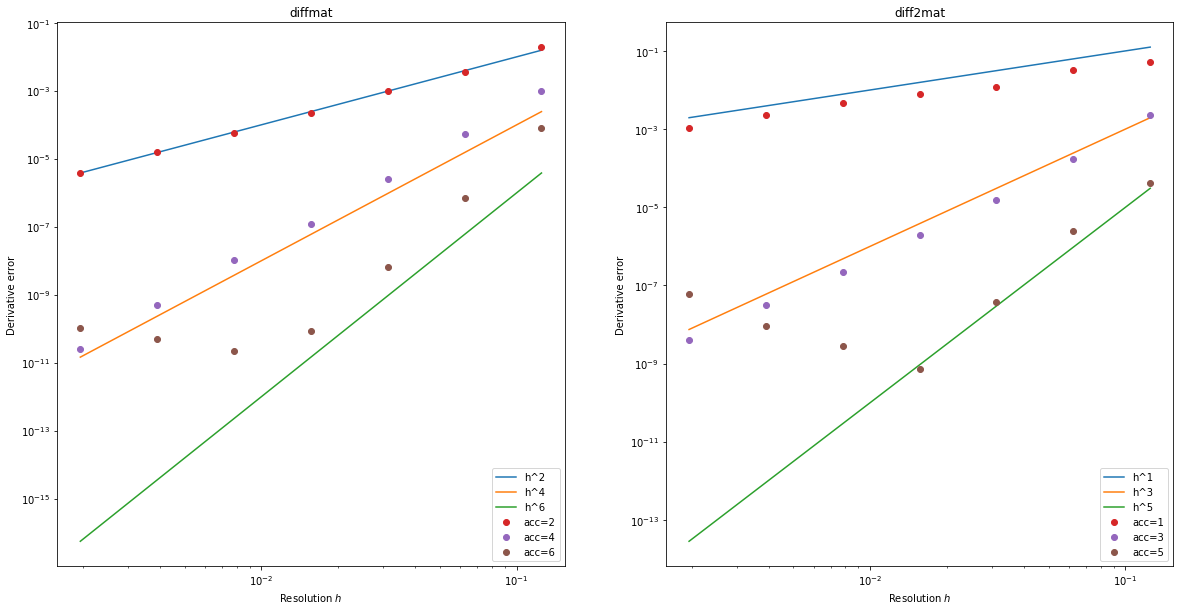

In [33]:
grids = 2**np.arange(3,10)
def grid_refinement_error(f, fp, diff, acc):
    error = []
    for n in grids:
        h = 2. / (n-1)
        x = np.linspace(-1,1,n)
        offset = np.random.uniform(-h/4., h/4., n-2)
        x[1:-1] += offset
        y = diff(x,acc).dot(f(x))
        error.append( np.linalg.norm(y - fp(x), np.inf) )
    return grids, error

fp = (np.cos,lambda x: -np.sin(x))
for i,diff in enumerate([diffmat, diff2mat]):
    plt.subplot(1,2,i+1, title=diff.__name__)
    plt.xlabel('Resolution $h$')
    plt.ylabel('Derivative error')
    plt.loglog(1./grids, grids**(-2.+i), label='h^'+str(2-i))
    plt.loglog(1./grids, grids**(-4.+i), label='h^'+str(4-i))
    plt.loglog(1./grids, grids**(-6.+i), label='h^'+str(6-i))
    for acc in [2,4,6]:
        ns, error = grid_refinement_error(np.sin, fp[i], diff, acc)
        plt.loglog(1./ns, error, 'o', label='acc='+str(acc-i))
    plt.legend(loc='lower right')


The higher order accurate settings appear to lose stability with finer granularity. Also, hold the stencil size constant (same size of stencil implies same degree of polynomial interpolant), $D_2$ offers slower convergence by a factor of $h$ as compared to $D$.